In [1]:

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse 
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix as sm
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score


In this project, we will take use some self-defined functions to plot the 2-D K-Means.

# Import Data
In this project, we use [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine) to cluster different types of wines. This data set contains the results of a chemical analysis of wines grown in a specific area of Italy.

The attributes are (dontated by Riccardo Leardi, riclea@anchem.unige.it ):
1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash  
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline 

Variable `Label` include the true labels of different wine.

In [2]:
wine = pd.read_csv('wine.data.csv', \
                   names = ['Label', \
                            'Alcohol', \
                            'Malic acid', \
                            'Ash', \
                            'Alcalinity of ash', \
                            'Magnesium', \
                            'Total phenols', \
                            'Flavanoids', \
                            'Nonflavanoid phenols', \
                            'Proanthocyanins', \
                            'Color intensity', \
                            'Hue', \
                            'OD280', \
                            'Proline'], header=0)
# True labels
label = wine['Label']
del wine['Label']
# Data description
print("Types of variables:\n",wine.dtypes)

wine.describe()

Types of variables:
 Alcohol                 float64
Malic acid              float64
Ash                     float64
Alcalinity of ash       float64
Magnesium                 int64
Total phenols           float64
Flavanoids              float64
Nonflavanoid phenols    float64
Proanthocyanins         float64
Color intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


From the table above we can get that there are 178 instances of wine and 13 attributes and for each attribute, the distribution differ a lot. Then we are going to plot the scatter plot of the dataset `wine` as follow:

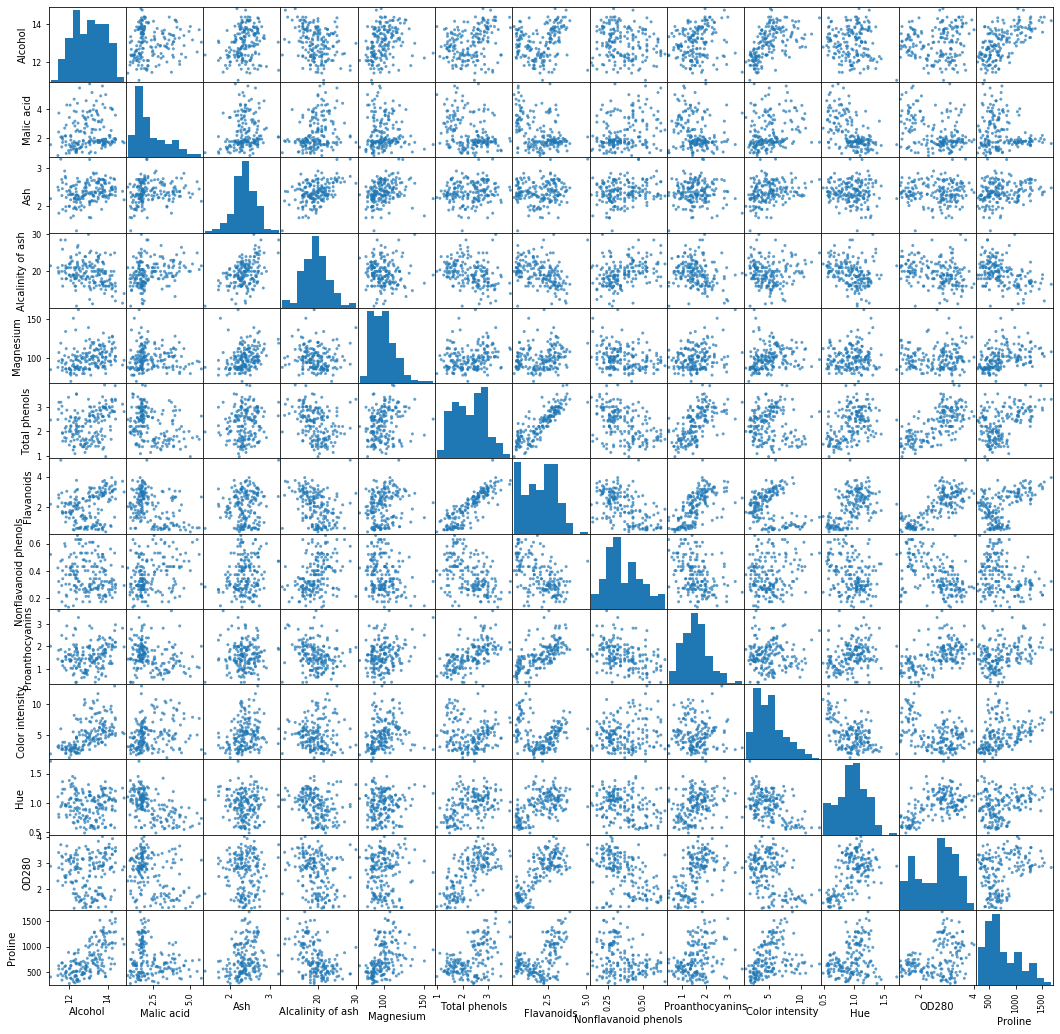

In [3]:
# Scatter plot
sm(wine, alpha = 0.7, figsize = (18,18))
plt.show()

From the scatter plot, it's hard for us to cluster the data.

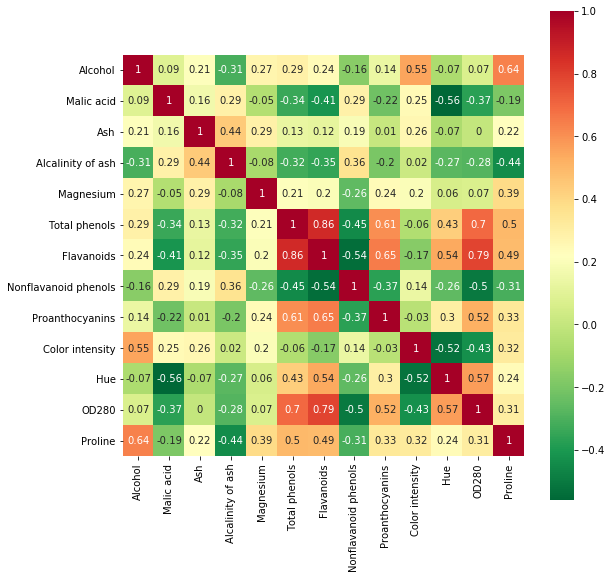

In [4]:
# Correlation Heatmap
correlation = wine.corr()
plt.subplots(figsize = (9,9))
sns.heatmap(correlation.round(2), 
            annot = True, 
            vmax = 1, 
            square = True, 
            cmap = 'RdYlGn_r')
plt.show()

From the heatmap above, we can conclude that the correlation between

* "Flavanoids" and "Total phenols" (`0.86`);
* "OD280" and "Flavanoids" (`0.79`);
* "OD280" and "Total phenols" (`0.7`);

are large.

Then we can plot the regression of "Flavanoids" on "Total phenols" as follow:

## Normalize data

We are going to normalize data by removing the mean and scaling to unit variance using `preprocessing.StandardScaler` and the table below show the general description statistics of normalized data.

In [5]:
scaler = preprocessing.StandardScaler()
scaler.fit(wine)
X_scaled_array = scaler.transform(wine)
winenorm = pd.DataFrame(X_scaled_array, columns = wine.columns)
winenorm.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


# [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)

In this part, we are going to cluster the `winenorm` dataset using K-Means method. The KMeans algorithm clusters data by trying to separate samples in `n` groups of equal variance, minimizing a criterion known as the **inertia** or within-cluster sum-of-squares (WSS).

## Choosing number of cluster

### Elbow Method

First of all, we are going to choose the number of cluster by [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 

Inertia is sum of squared distances of samples to their closest cluster center. And the Elbow method looks at the inertia as a function of the number of clusters. One should choose a number of clusters so that adding another cluster doesn’t improve much better the inertia.



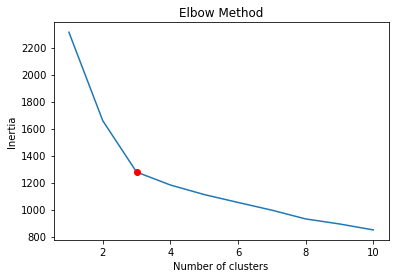

In [6]:
#Elbow Method
seed = 0
elbow = dict()
for k in range(1,11):
    estimator = KMeans(n_clusters = k,random_state=seed)
    res = estimator.fit_predict(winenorm)
    inertia = estimator.inertia_
    elbow[k] = inertia
    
elbow_df = pd.Series(elbow)
ax = elbow_df.plot(title = 'Elbow Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
plt.plot(3,elbow_df[3],'ro')

From the figure above, we can see that when the number of cluster is 3, average silhouette score is maximized.

Thus we choose the number of cluster to be **3**.

## K-Means

In [7]:
KM = KMeans(n_clusters = 3, random_state=seed)
res = KM.fit_predict(winenorm)

label_pred_KM = KM.labels_ + 1
print("Labels predicted by K-Means:",label_pred_KM)
print('Length of labels is same as data entry', label_pred_KM.shape)

centroids_KM= KM.cluster_centers_
print("Shape of centroids_KM",centroids_KM.shape)
print("Centroids:",centroids_KM)

inertia_KM = KM.inertia_
print("Inertia:",inertia_KM)


Labels predicted by K-Means: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 3 2 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 2 2 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Length of labels is same as data entry (178,)
Shape of centroids_KM (3, 13)
Centroids: [[ 0.83523208 -0.30380968  0.36470604 -0.61019129  0.5775868   0.88523736
   0.97781956 -0.56208965  0.58028658  0.17106348  0.47398365  0.77924711
   1.12518529]
 [-0.92607185 -0.39404154 -0.49451676  0.17060184 -0.49171185 -0.07598265
   0.02081257 -0.03353357  0.0582655  -0.90191402  0.46180361  0.27076419
  -0.75384618]
 [ 0.16490746  0.87154706  0.18689833  0.52436746 -0.07547277 -0.97933029
  -1.21524764  0.72606354 -0.77970639  0.94153874 -1.16478865 -1.29241163
  -0.40708796]]
Inertia: 1277.928488844643


We can plot the pairwise relationships of `winenorm` with the colored label predicted bt K-Means method.

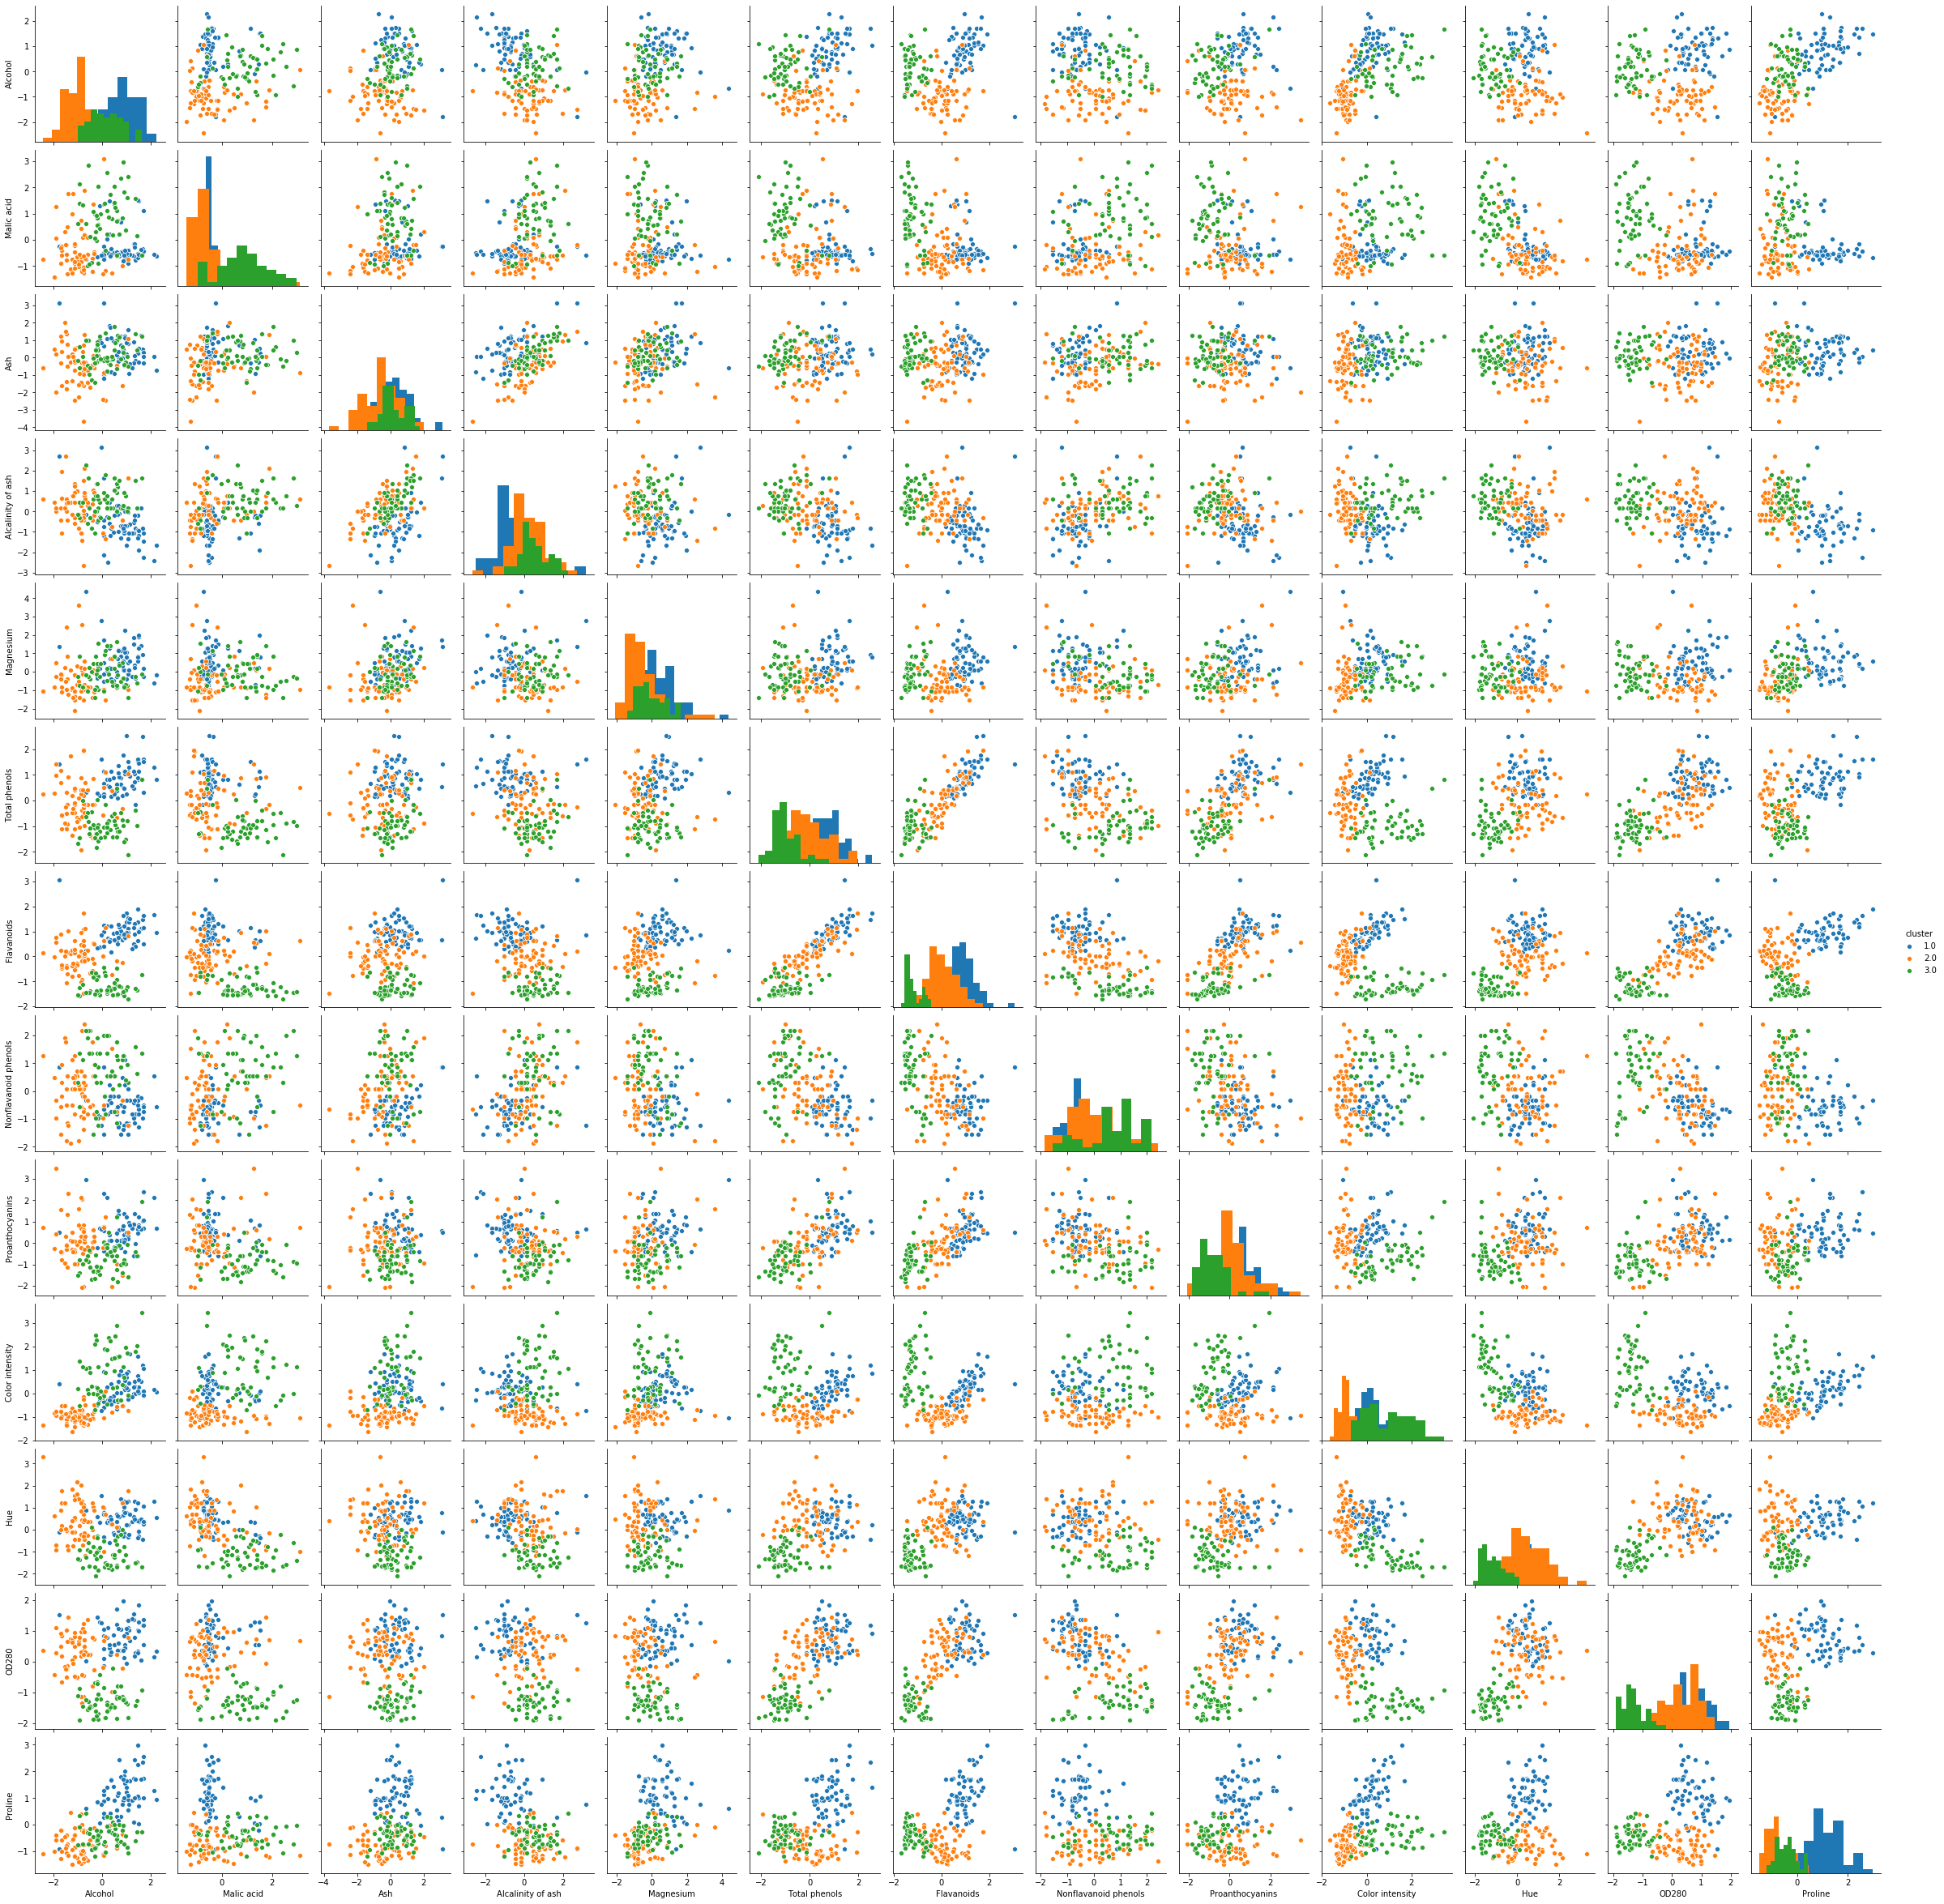

In [8]:
# Pairplot
winenorm["cluster"] = label_pred_KM.astype('float64')
sns_plot = sns.pairplot(winenorm, hue = "cluster",diag_kind="hist")

# [Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)

We can take use of PCA to reduce the dimension of dataset.

First of all, we are going to generate the 13 Principal Component (PA) of `winenorm` and check the amount and percentage of of variance explained by each of the selected components.

Then we will compute the singular values corresponding to each of the selected components. 

In [9]:
pca = PCA(random_state=seed)
pca.fit(winenorm)
winenorm_pca_array = pca.transform(winenorm)
winenorm_pca = pd.DataFrame(winenorm_pca_array)
print("Heads of wine_pca:",winenorm_pca.head())
var_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:",var_ratio)
sv = pca.singular_values_
print("Singular Value:",sv)

Heads of wine_pca:           0         1         2         3         4         5         6  \
0 -3.443444 -1.442444 -0.194331 -0.144347  0.719266 -0.236848  0.574393   
1 -2.393225  0.333881 -2.020206 -0.360429 -0.290743 -0.939286  0.008662   
2 -2.687163 -1.030563  0.964986  0.729270 -0.279737  0.512199  0.461208   
3 -3.855793 -2.755103 -0.217720  0.591965 -0.306054  0.199773 -0.395245   
4 -1.273563 -0.870105  2.047494 -0.417348  0.290820 -0.474278  0.435580   

          7         8         9        10        11        12        13  
0  0.058485  0.560301  1.000364 -0.515680  0.524182 -0.233306 -0.265433  
1  1.025028 -0.294096  0.080343 -0.159296  0.383932 -0.034148 -0.013674  
2 -0.322522 -1.191018 -0.031202 -0.302564 -0.001363  0.012884  0.019171  
3  0.636636  0.062601  0.200556  0.726937 -0.260975 -0.488312 -0.144386  
4  0.416226  0.321726 -0.021838 -0.506599 -0.204425  0.098652  0.409868  
Explained variance ratio: [0.38460865 0.1831834  0.10631346 0.06778672 0.06297798 0.04

## Plot out the cumulative explained variance ratio

We are going to plot the cumulative explained variance ratio for each PCs.

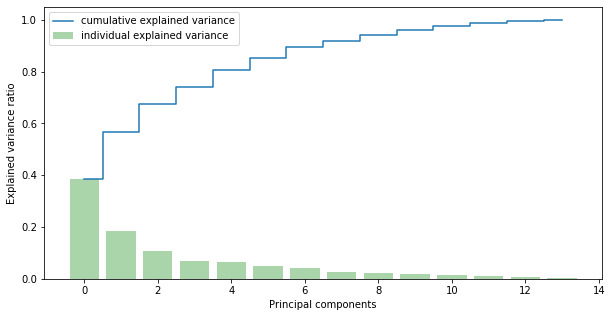

Cumulative explained ratio: [0.38460865 0.56779205 0.67410551 0.74189222 0.8048702  0.85315465
 0.89371867 0.91931229 0.94068276 0.95966128 0.97625118 0.98863926
 0.99715384 1.        ]


In [10]:
cum_var_ratio = np.cumsum(var_ratio)
plt.figure(figsize=(10, 5))
plt.bar(range(len(var_ratio)), 
        var_ratio, 
        alpha=0.3333, 
        align='center', 
        label='individual explained variance', 
        color = 'g')
plt.step(range(len(cum_var_ratio)),
         cum_var_ratio, 
         where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()


print("Cumulative explained ratio:",cum_var_ratio)

# PCA and Cluster

In this part, we are going to select top six principal components and transform the dataset `winenorm`. Then we are going to run K-Means and GMM model on this dimension reduced dataset.

In [11]:
# we slecte six components
pca = PCA(n_components = 6, random_state=seed)
pca.fit(winenorm)
winenorm_pca_array = pca.transform(winenorm)
winenorm_PCA = pd.DataFrame(winenorm_pca_array)
var_ratio = pca.explained_variance_ratio_
print("Sum of top 6 PCs:",sum(var_ratio[0:5]))

# K-Means + PCA
KM = KMeans(n_clusters = 3, random_state=seed)
res = KM.fit(winenorm_PCA)
label_pred_KM_PCA = KM.predict(winenorm_PCA)
print("Labels predicted by KM+PCA:",label_pred_KM_PCA)

# GMM + PCA
GMM = GaussianMixture(n_components = 3, random_state=seed)
res_GMM = GMM.fit(winenorm_PCA)
label_pred_GMM_PCA = GMM.predict(winenorm_PCA)
print("Labels predicted by GMM+PCA:",label_pred_KM_PCA)

Sum of top 6 PCs: 0.8048702036807859
Labels predicted by KM+PCA: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Labels predicted by GMM+PCA: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


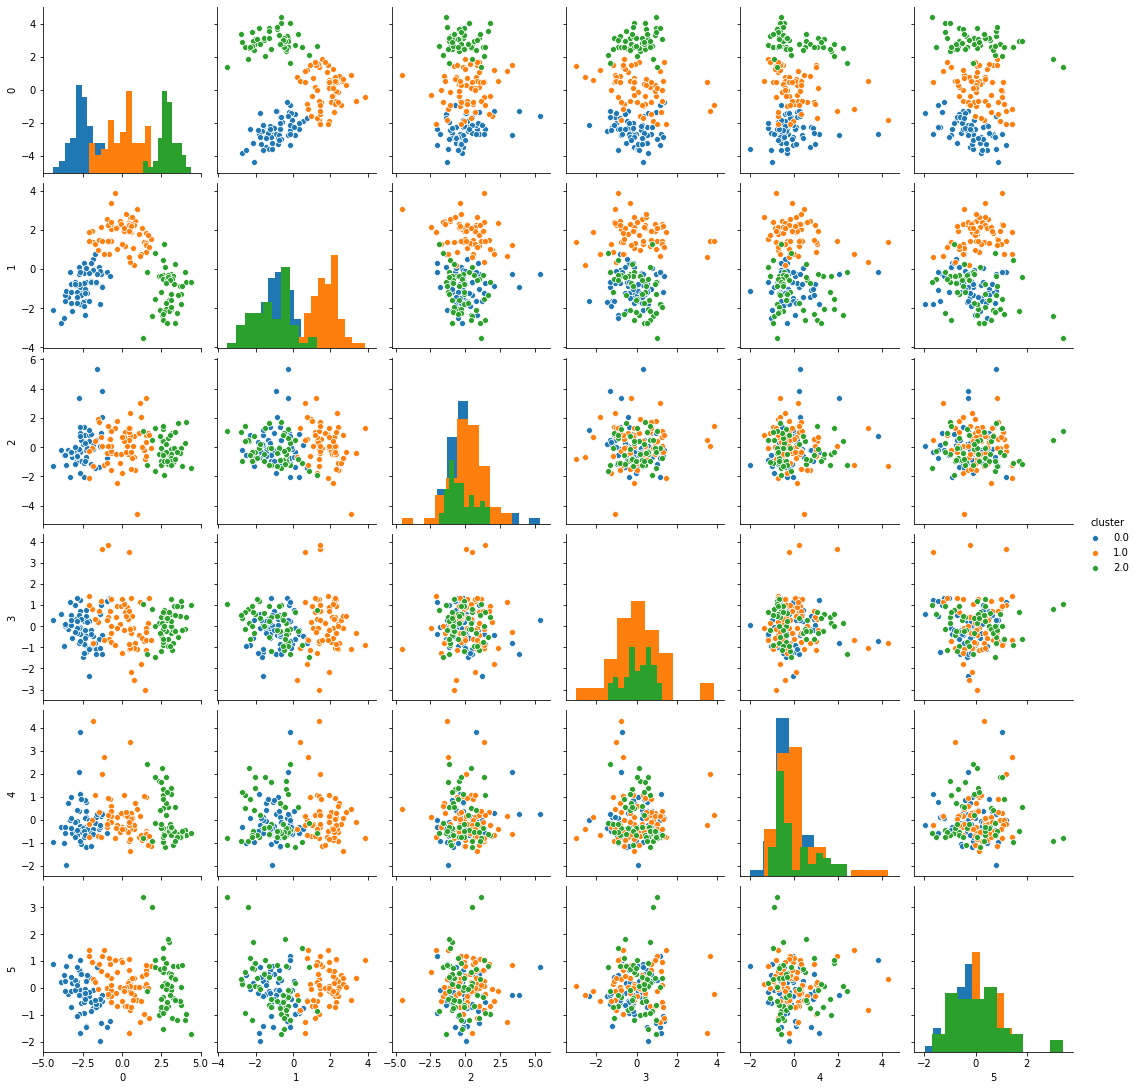

In [12]:
# Pairplot of KM
winenorm_PCA['cluster'] = label_pred_KM_PCA.astype('float64')
sns_plot = sns.pairplot(winenorm_PCA, hue = "cluster",diag_kind="hist")

# Evaluation


## [Rand index](https://en.wikipedia.org/wiki/Rand_index) adjusted for chance

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

`ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)`

We compare the predicted label with true label provided. Thus the higher the Rand Index, the more precise the cluster is.

In [13]:
ar_score_KM = adjusted_rand_score(label, label_pred_KM)
print("Adjusted Rand Index of cluster by KM:",ar_score_KM)

ar_score_KM_PCA = adjusted_rand_score(label, label_pred_KM_PCA)
print("Adjusted Rand Index of cluster by KM+PCA:",ar_score_KM_PCA)


Adjusted Rand Index of cluster by KM: 0.8974949815093207
Adjusted Rand Index of cluster by KM+PCA: 0.8974949815093207
